# 数据预处理

In [1]:
import pandas as pd
import os
import glob
import os
import matplotlib.pyplot as plt
import jieba
import jieba.posseg as pseg
import jieba.analyse
import numpy as np
import torch
from sklearn.model_selection import train_test_split
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline

## 读取数据并预处理

In [2]:
# use glob to get all the csv files 
# in the folder
path = r"./data/source_data/"
csv_files = glob.glob(os.path.join(path, "*.csv"))
df_all = pd.DataFrame({"弹幕":[],"类别":[]})
print(df_all.columns)
df = 0
for f in csv_files:
    df = pd.read_csv(f) 
    df = df.iloc[:,-2:]
    df.columns = ["弹幕", "类别"]   
    df_all = pd.concat([df_all, df],axis=0)
    # print(df_all["弹幕"][0])  

df_all.dropna(inplace=True) 
df_all["类别"] = df_all["类别"].apply(lambda x: int(x))
df_all.drop_duplicates(subset=["弹幕","类别"],keep='first',inplace=True)

path = r"./data-extra"
csv_files = glob.glob(os.path.join(path, "*.csv"))
df_all_extra = pd.DataFrame({"弹幕":[],"类别":[]})
print(df_all_extra.columns)
df = 0
for f in csv_files:
    df = pd.read_csv(f) 
    df = df.iloc[:,:2]
    df.columns = ["弹幕", "类别"]   
    df_all_extra = pd.concat([df_all_extra, df],axis=0)
df_all_extra.dropna(inplace=True) 
df_all_extra["类别"] = df_all_extra["类别"].apply(lambda x: int(x))
df_all_extra.drop_duplicates(subset=["弹幕","类别"],keep='first',inplace=True)


df_all = pd.concat([df_all, df_all_extra],axis=0)
df_all

Index(['弹幕', '类别'], dtype='object')
Index(['弹幕', '类别'], dtype='object')


,弹幕,类别
0,你代言都和他接同一家？？？？,2.0
1,《我 很 内 向》,1.0
2,不管是不是笋 秀芬看到即爽到,0.0
3,你好爱他,0.0
5,西蒙他老婆的战歌,0.0
...,...,...
3588,是的，只有团结才有力量,0.0
3590,艾吉奥,0.0
3593,张三老师好有哲理,0.0
3594,张三老师好,0.0


In [3]:
# labels = ["高兴","难过","愤怒","惊讶","负样本"]
# for i in range(len(labels)):
#     df_all["类别"][df_all["类别"]==i] = labels[i]
# df_all

## 分词

In [4]:
"""
    加载本地字典：
    【1】自定义字典
    【2】停用词字典
"""
local_dic_name = './data/userdict.txt'
local_stopwords_name = './data/stopwords_dic.txt'
jieba.load_userdict(local_dic_name)
jieba.load_userdict(local_stopwords_name)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Sion\AppData\Local\Temp\jieba.cache
Loading model cost 0.610 seconds.
Prefix dict has been built successfully.


In [5]:
dataset_x = []
dataset_y = []
for i in range(len(df_all)):
    str_t = str(df_all.iloc[i]["弹幕"])
    label = int(df_all.iloc[i]["类别"])
    word_list = jieba.lcut(str_t)
    dataset_x.append(word_list)
    dataset_y.append(label)

In [6]:
dataset_x[:5],dataset_y[:5]

([['你', '代言', '都', '和', '他', '接同', '一家', '？', '？', '？', '？'],
  ['《', '我', ' ', ' ', ' ', '很', ' ', ' ', ' ', '内', ' ', ' ', ' ', '向', '》'],
  ['不管', '是不是', '笋', ' ', '秀芬', '看到', '即爽', '到'],
  ['你好', '爱', '他'],
  ['西蒙', '他', '老婆', '的', '战歌']],
 [2, 1, 0, 0, 0])

## 去除停用词(暂时不使用)

In [7]:
# """
#     函数功能：创建停用词list
#     参数：
#         filepath：停用词典地址
#     返回：
#          停用词list
# """
# def stopwordslist(local_stopwords_name):
#     stopwords = [line.strip() for line in open(local_stopwords_name, 'r', encoding='utf-8').readlines()]
#     return stopwords

# stopwords = stopwordslist(local_stopwords_name)

# def word_filter(result):
#     stopwords = stopwordslist(local_stopwords_name)
#     body = ''
#     for w in result:
#         if w.flag != 'x' and w.flag != 'r' and w.flag != 'ul' \
#                 and w.flag != 'uj' and w.flag != 'y' and w.flag != 'q'\
#                 and w.flag != 'd' and w.flag != 'm' and w.flag != 'eng':
#             if w.word not in stopwords:
#                 body += w.word + '\n'
#     # 提取关键词
#     tag = jieba.analyse.extract_tags(body, 5)
#     # print(tag)
#     # 生成关键词比重词典
#     # key = jieba.analyse.textrank(body, topK=100, withWeight=True)
#     # keywords = dict()
#     # for i in key:
#     #    keywords[i[0]] = i[1]
#     # print(keywords)
#     return body


# for i in range(len(dataset)):
#     dataset[i][0] = word_filter(dataset[i][0])

# dataset[:5]

## 根据词频OneHot编码（暂时不用）

In [8]:
# # 将原始训练和测试文本转化为特征向量
# from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
# # count_vec=CountVectorizer() #创建词袋数据结构
# count_vec=TfidfVectorizer() #根据词频-逆文档频率
# dataset_count_x = count_vec.fit_transform(dataset_x) 
# dataset_count_x= dataset_count_x.toarray()

## Word2Vec

In [9]:
from gensim.models.word2vec import Word2Vec
# 训练word to vector 的 word embedding
model = Word2Vec(dataset_x,     # 上文处理过的全部语料
                 min_count=1,  # 词频阈值 词出现的频率 小于这个频率的词 将不予保存
                 workers=12, # worker是线程数
                 window=5  # 窗口大小 表示当前词与预测词在一个句子中的最大距离是多少
                 )
# model.save('./models/Word2vec_v1')  # 保存模型

In [10]:
# import gensim
# model = gensim.models.Word2Vec.load("./models/Word2vec_v1")#加载
# # 获取词向量
# model.wv.get_vector("狂喜").shape

In [11]:
# 转换分词->向量
dataset_vector_x = []
for sentence,label in zip(dataset_x,dataset_y):
    vector_x = []
    for word in sentence:
        vector_x.append(model.wv.get_vector(word))
    dataset_vector_x.append(vector_x)

## 标签OneHot编码

In [12]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
dataset_y = np.array(dataset_y).reshape(-1,1)
enc.fit(dataset_y)
dataset_onehot_y = enc.transform(dataset_y).toarray()
dataset_onehot_y.shape

(5007, 4)

## 分割数据集

In [13]:
x_train,x_test,y_train,y_test = train_test_split(
    dataset_vector_x,dataset_onehot_y,test_size=0.2,random_state=1)

## 按类别统计样本数(过采样前)

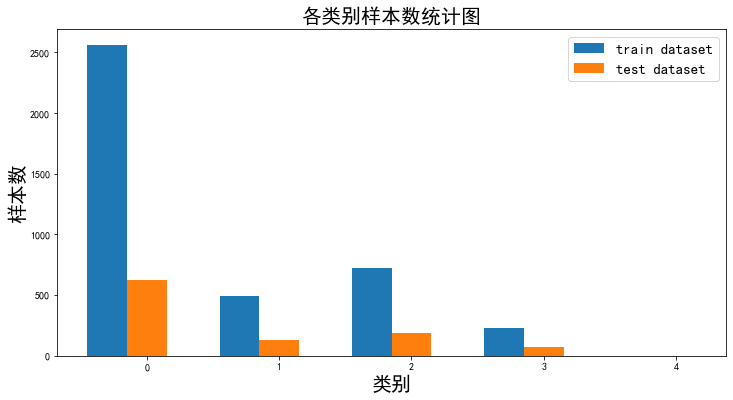

train dataset: [2562.  490.  725.  228.    0.]
test  dataset: [626. 125. 184.  67.   0.]


In [14]:
name_list = range(5)
train_data = np.zeros(5)
test_data = np.zeros(5)
for i in range(len(x_train)):
    y = np.argmax(y_train[i,:],axis=0)
    train_data[y] += 1
for i in range(len(x_test)):
    y = np.argmax(y_test[i,:],axis=0)
    test_data[y] += 1
font = {'size' : 20}
width=0.3;#柱子的宽度
index=np.arange(len(name_list))
plt.figure(figsize=(12,6))
plt.bar(index, train_data,width, tick_label=range(5), label='train dataset')
plt.bar(index+width, test_data,width, tick_label=range(5), label='test dataset')
plt.title('各类别样本数统计图',font)
plt.ylabel('样本数',font)
plt.xlabel('类别',font)
plt.legend(fontsize=15)
plt.show()
print('train dataset:',train_data)
print('test  dataset:', test_data)

## 过采样(只针对训练集)

In [15]:
# def oversampling(dataset_x,dataset_y): 
#     dataset_new_x = []
#     dataset_new_y = []
#     for sentence,label in zip(dataset_x,dataset_y):
#         label_val = np.argmax(label,axis=0)
#         # 对样本数比较少的类别进行过采样
#         if label_val in [1,2,3]:
#             for i in range(4):
#                 dataset_new_x.append(sentence)
#                 dataset_new_y.append(label)
#         if label_val == 0:
#             for i in range(2):
#                 dataset_new_x.append(sentence)
#                 dataset_new_y.append(label)
#         else:
#             dataset_new_x.append(sentence)
#             dataset_new_y.append(label)
#     return dataset_new_x, np.array(dataset_new_y)
# x_train,y_train = oversampling(x_train,y_train)

## 按类别统计样本数(过采样后)

In [16]:
# name_list = range(5)
# train_data = np.zeros(5)
# test_data = np.zeros(5)
# for i in range(len(x_train)):
#     y = np.argmax(y_train[i,:],axis=0)
#     train_data[y] += 1
# for i in range(len(x_test)):
#     y = np.argmax(y_test[i,:],axis=0)
#     test_data[y] += 1
# font = {'size' : 20}
# width=0.3;#柱子的宽度
# index=np.arange(len(name_list))
# plt.figure(figsize=(12,6))
# plt.bar(index, train_data,width, tick_label=range(5), label='train dataset')
# plt.bar(index+width, test_data,width, tick_label=range(5), label='test dataset')
# plt.title('各类别样本数统计图',font)
# plt.ylabel('样本数',font)
# plt.xlabel('类别',font)
# plt.legend(fontsize=15)
# plt.show()
# print('train dataset:',train_data)
# print('test  dataset:', test_data)

## 保存数据集

In [17]:
torch.save(x_train,"dataset/x_train")
torch.save(y_train,"dataset/y_train")
torch.save(x_test,"dataset/x_test")
torch.save(y_test,"dataset/y_test")